# Hero Quest: Combat Probabilities
In this exercise I will compute the probabilities for each outcome when a creature in the board game "Hero: Quest" attacks another creature.
### Combat System
When a creature attacks another, it rolls a six-sided die for each strength points it has, then counts the number of skulls rolled.
The defender then rolls a die for each defense value it has. Each shield (black if it's a monster, white otherwise) rolled blocks one skull.
The defender then looses a body point for each unblocked skull.
It dies when it has no body points.

### Theory
* Rolling n dice, what is the probability of getting k hits, with s being the probability of rolling a skull per dice?

For this question, a die outcome can be seen as either a skull or not a skull.
The probability of rolling a skull stays the same, so this is a Bernoulli trial B(n, s) where n is the number of dice rolled and s the probability of success, which is the probability of rolling a skull.
$$P(k) = \begin{pmatrix}n \\ k\end{pmatrix}p^k(1-p)^{n-k}$$
$$P(k) = \frac{n!}{k!(n-k)!}p^k(1-p)^{n-k}$$

* What about when a hero or monster rolls dice to defend himself?

Here the principle is exactly the same, this is again a Bernoulli trial, we just have to adjust the value of s, as the probability of success will now be the probability of rolling a shield (black or white, depending on if it's a monster or a hero).

### How will we proceed?
To simulate on entire attack, we look at:
* the attacker rolling a dice. We will compute the probabilities that he rolls n skulls, for n between 0 and a
* the defender rolling d dice. We will compute the probabilities that he rolls n shields, for n between 0 and d
* combining these results to compute the probabilties that the defender takes n damage, for n between 0 and a
* translating the previous results into outcome probabilities (deal n damage, kill)
* visualizing these probabilities with a horizontal bar plot

#### What does a combat die look like?
![Die faces](https://www.heroscribe.org/hqdice.png)

In [67]:
def factorial(n):
    return 1 if n <= 1 else n * factorial(n - 1)

def bernoulli(k, n, p):
    n_choose_k = factorial(n) / (factorial(k) * factorial(int(n-k)))
    return n_choose_k * p**k * (1-p)**(n-k)

def compute_skull_probas(n_dice, skull_proba):
    # associates the number of skulls rolled with the proba that it occurs
    skulls_probas = {}
    for skulls_wanted in range(0, n_dice + 1):
        skulls_probas[skulls_wanted] = bernoulli(skulls_wanted, n_dice, skull_proba)    
    return skulls_probas

def compute_shield_probas(n_defense_dice, shield_proba):
    # assiciates a number of shield rolled with the proba that it occurs
    shields_probas = {}
    for shields in range(0, n_defense_dice + 1):
        shields_probas[shields] = bernoulli(shields, n_defense_dice, shield_proba)
    return shields_probas

def compute_damage_probas(skulls_probas, shield_probas):
    # associates the number of damage dealt with the probability that it occurs
    damage_probas = {}
    # for each combination of skulls & shields rolled, we compute the probability of these two events occuring
    #(the two events are independent so we just multiply the probabilities)
    #then according to the damage this will represent in the end, we update the probability (set or add) that 
    #this amount of damage occurs
    for skulls, sk_proba in skulls_probas.items():
        for shields, sh_proba in shield_probas.items():
            proba_of_this_intersection = sk_proba * sh_proba
            damage_dealt = abs(skulls - shields)
            if damage_dealt in damage_probas:
                 damage_probas[damage_dealt] += proba_of_this_intersection
            else:
                damage_probas[damage_dealt] = proba_of_this_intersection
    return damage_probas

def compute_outcome_probas(damage_probas, enemy_health):
    # associates an outcome with the probability that it occurs (deal n damage or kill)
    outcome_probas = {}
    for damage_dealt, damage_proba in damage_probas.items():
        outcome = str(damage_dealt) + " damage" if damage_dealt < enemy_health else "kill"
        if outcome in outcome_probas:
            outcome_probas[outcome] += damage_proba
        else:
            outcome_probas[outcome] = damage_proba
    return outcome_probas

# A hero or creature rolls 3 dice, with each having a 50% of being a skull
skulls_probas = compute_skull_probas(3, .5)
skulls_probas

{0: 0.125, 1: 0.375, 2: 0.375, 3: 0.125}

We read this dictionary as follow:
* There is a 12.5% (1/8) chance that the hero rolls 0 skull
* There is a 37.5% (3/8) chance that the hero rolls 1 skull
* There is a 37.5% (3/8) chance that the hero rolls 2 skulls
* There is a 12.5% (1/8) chance that the hero rolls 3 skulls

In [68]:
# The monster defends himself with 2 dice, each having a 1/6 probability of being a black skull
# Note that this experiment is independent of the results of the attack experiment
shields_probas = compute_shield_probas(2, 1/6)
shields_probas

{0: 0.6944444444444445, 1: 0.2777777777777778, 2: 0.027777777777777776}

We read this dictionary as follow:
* There is around 69% chance that the monster rolls 0 black shield
* There is around 28% chance that the monster rolls 1 black shield
* There is around 3% chance that the monster rolls 2 black shields

In [69]:
# Now we combine our dictionaries to compute the probability of each damage amount
damage_probas = compute_damage_probas(skulls_probas, shields_probas)
damage_probas

{0: 0.2013888888888889,
 1: 0.4131944444444445,
 2: 0.2986111111111111,
 3: 0.08680555555555557}

We read this dictionary as follow:
* There is around 20% chance that the monster will take no damage
* There is around 41% chance that the monster will take 1 damage
* There is around 30% chance that the monster will take 2 damage
* There is around 9% chance that the monster will take 3 damage

In [70]:
# Finally, we translate our damage probas into outcome probas by taking into consideration the  monster's body points
# We simulate it as if the monster has 2 body points
outcome_probas = compute_outcome_probas(damage_probas, 2)
outcome_probas

{'0 damage': 0.2013888888888889,
 '1 damage': 0.4131944444444445,
 'kill': 0.3854166666666667}

We just summed the proabilities that ended up giving the same outcome: a kill (in this case, the 2 and 3 damage outcomes)

We read this dictionary as follow:
* There is around 20% chance to deal 0 damage to the monster
* There is around 41% chance to deal 1 damage to the monster
* There is around 39% chance to kill the monster (P(2 damage) + P(3 damage))

#### Visualization
We can draw a horizontal bar plot to quickly review and contrast the probabilities of our outcomes:

<IPython.core.display.Javascript object>


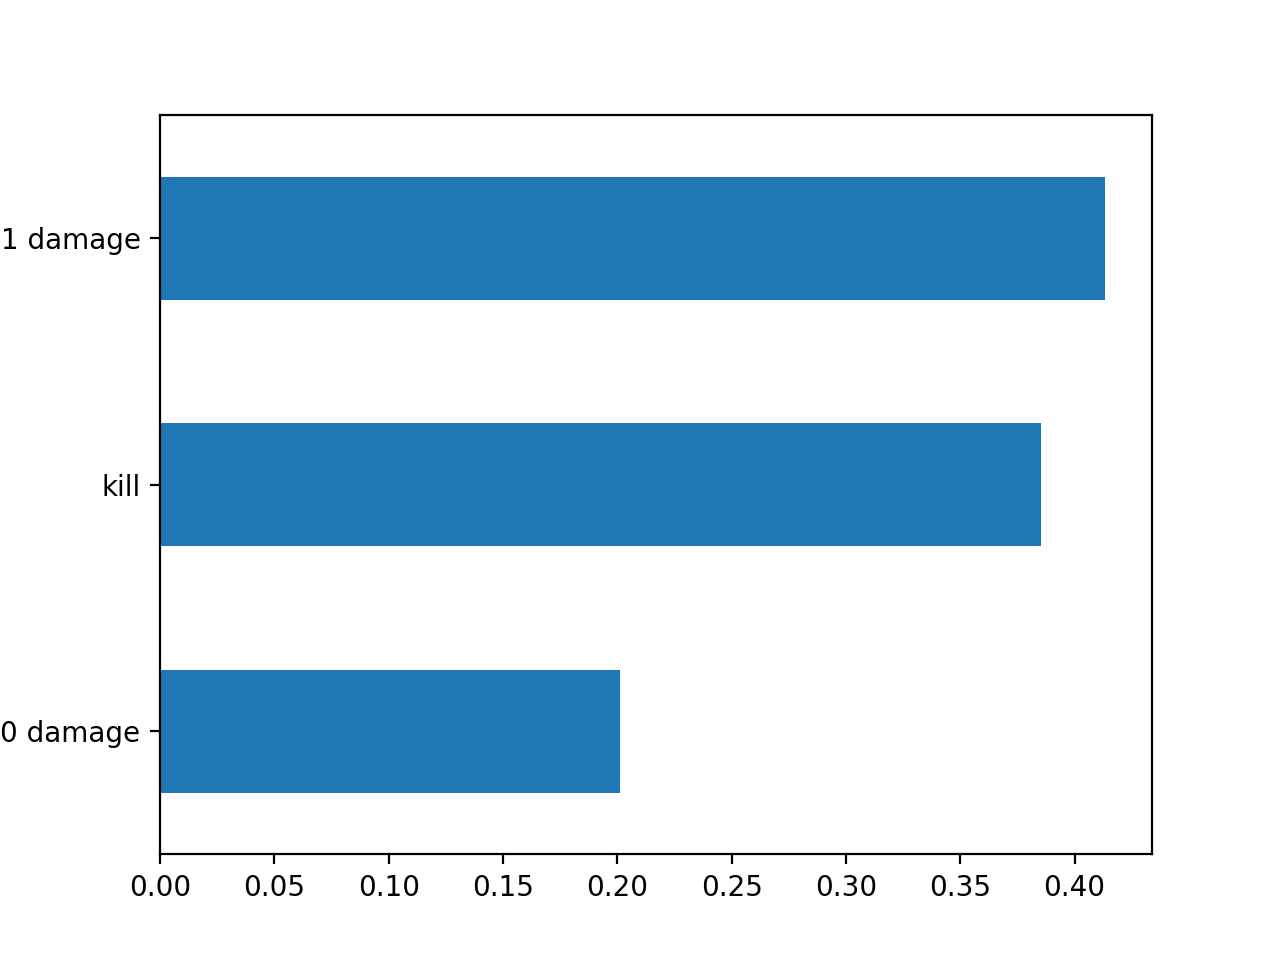

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

outcome_series = pd.Series(outcome_probas)
# we sort the values to rank them by probability
outcome_series.sort_values().plot.barh()

### Making the program more structured and scalable with Object-Oriented Programming
In this section we will create two classes:
* Creature: represents a hero or a monster. Stores its combat stats, name, and if it's a hero or not. Can use our previous functions to simulate an attack and display the probability of the outcomes
* Dice_model: represents the probabilities to get any particular outcome out of one die

We will then creature a few instances of creatures (heroes & monsters) and one instance of a die model.

In [72]:
class Creature:
    
    def __init__(self, name, attack_dice, defense_dice, body_points, isHero=False):
        self.name = name
        self.attack_dice = attack_dice
        self.defense_dice = defense_dice
        self.body_points = body_points
        self.isHero = isHero
        
    def simulate_attack(self, dice_model, other_creature):
        # The probability for each dice to be give a defense point depends on wether the defending creature is a hero or a monster
        defender_shield_proba = dice_model.black_shield_proba if self.isHero else dice_model.white_shield_proba
        
        skulls_probas = compute_skull_probas(self.attack_dice, dice_model.skull_proba)
        shields_probas = compute_shield_probas(other_creature.defense_dice, defender_shield_proba)
        damage_probas = compute_damage_probas(skulls_probas, shields_probas)
        outcome_probas = compute_outcome_probas(damage_probas, other_creature.body_points)
        
        outcome_series = pd.Series(outcome_probas).sort_values()
        self.plot_outcomes(outcome_series, other_creature)
        return outcome_series
    
    def plot_outcomes(self, outcome_series, other_creature):
        title = self.name + " attacks " + other_creature.name
        
        %matplotlib notebook
        outcome_series.plot.barh(title = title)
        
        
class Dice_model:
    
    def __init__(self, skull_proba, white_shield_proba, black_shield_proba):
        self.skull_proba = skull_proba
        self.white_shield_proba = white_shield_proba
        self.black_shield_proba = black_shield_proba

barbarian = Creature("Barbarian", 3, 2, 8, True)
dwarf = Creature("Dwarf", 2, 2, 7, True)
chaos_warrior = Creature("Chaos Warrior", 3, 4, 1)
goblin = Creature("Goblin", 2, 1, 1)
skeleton = Creature("Skeleton", 2, 2, 1)
big_gargoyle = Creature("Big Gargoyle", 4, 4, 2)
custom_boss = Creature("Custom Boss", 5, 5, 3)

dice = Dice_model(.5, 1/3, 1/6)

### Simulations
In this section we will test our program out by computing and displaying the probabilities of the outcomes of several fights

<IPython.core.display.Javascript object>


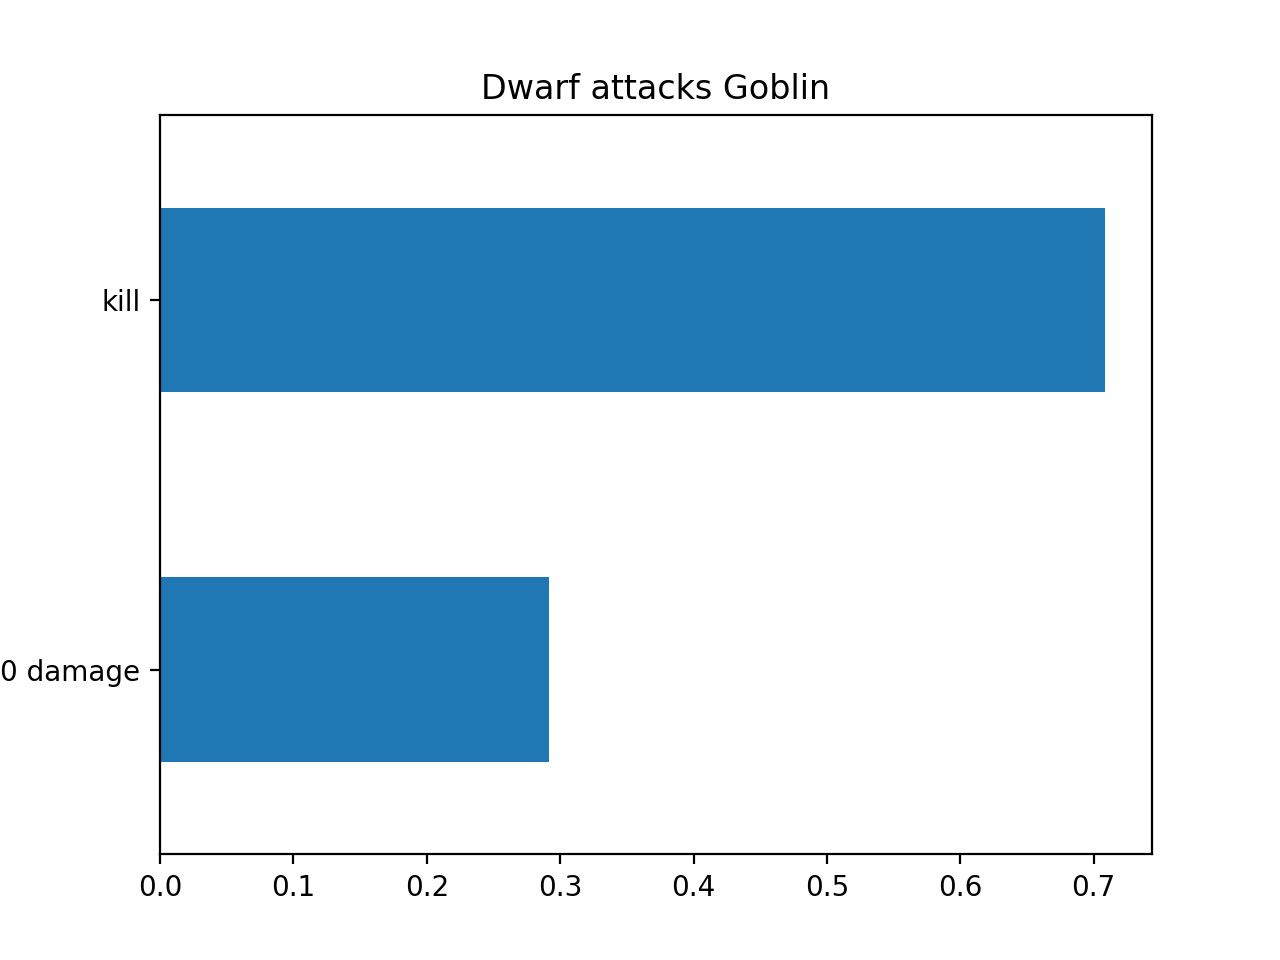

0 damage    0.291667
kill        0.708333
dtype: float64

In [78]:
# A dwarf attacks a goblin
dwarf.simulate_attack(dice, goblin)

<IPython.core.display.Javascript object>


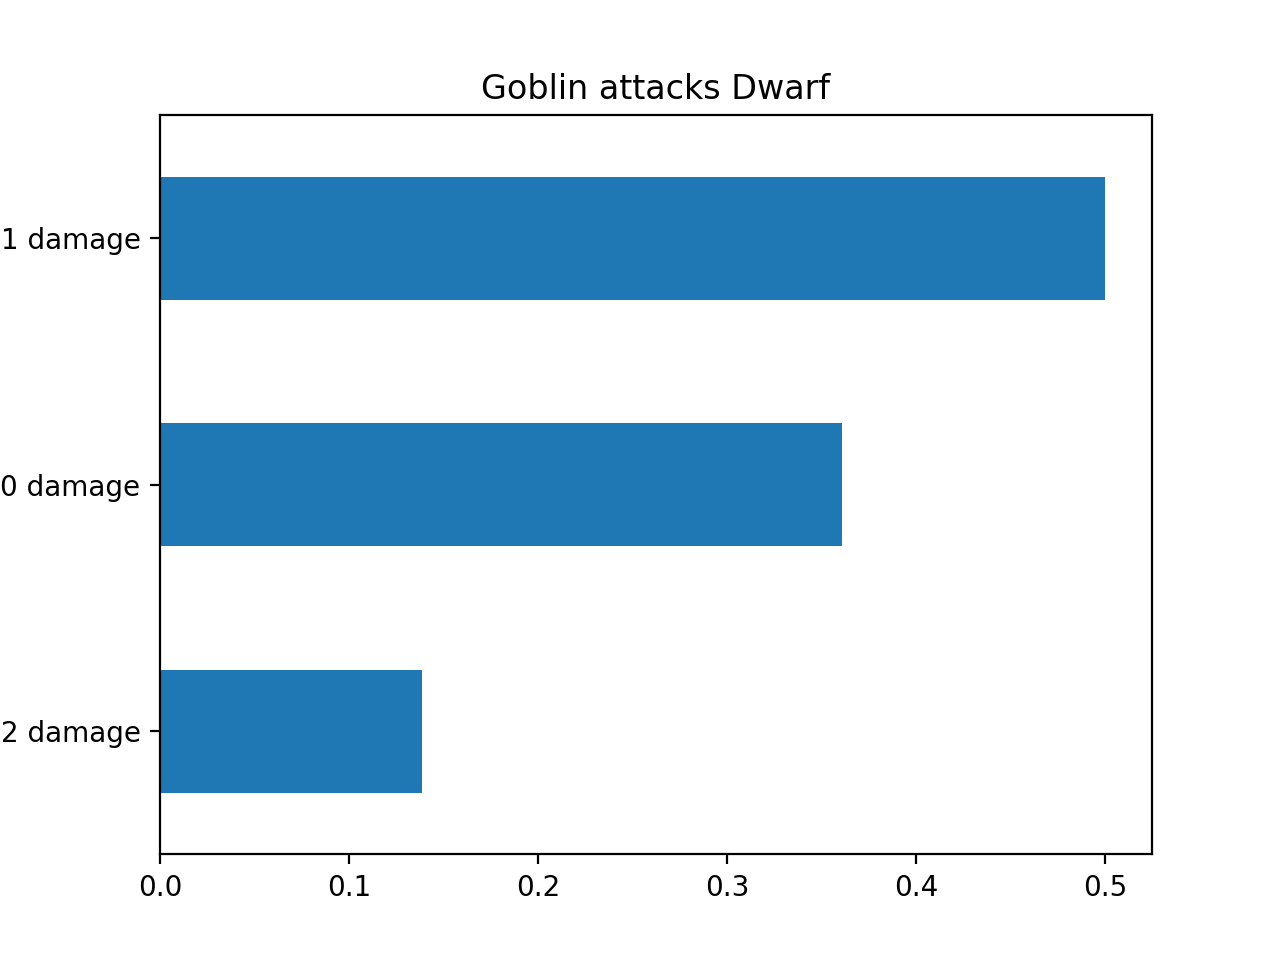

2 damage    0.138889
0 damage    0.361111
1 damage    0.500000
dtype: float64

In [79]:
# A goblin attacks a dwarf
goblin.simulate_attack(dice, dwarf)

<IPython.core.display.Javascript object>


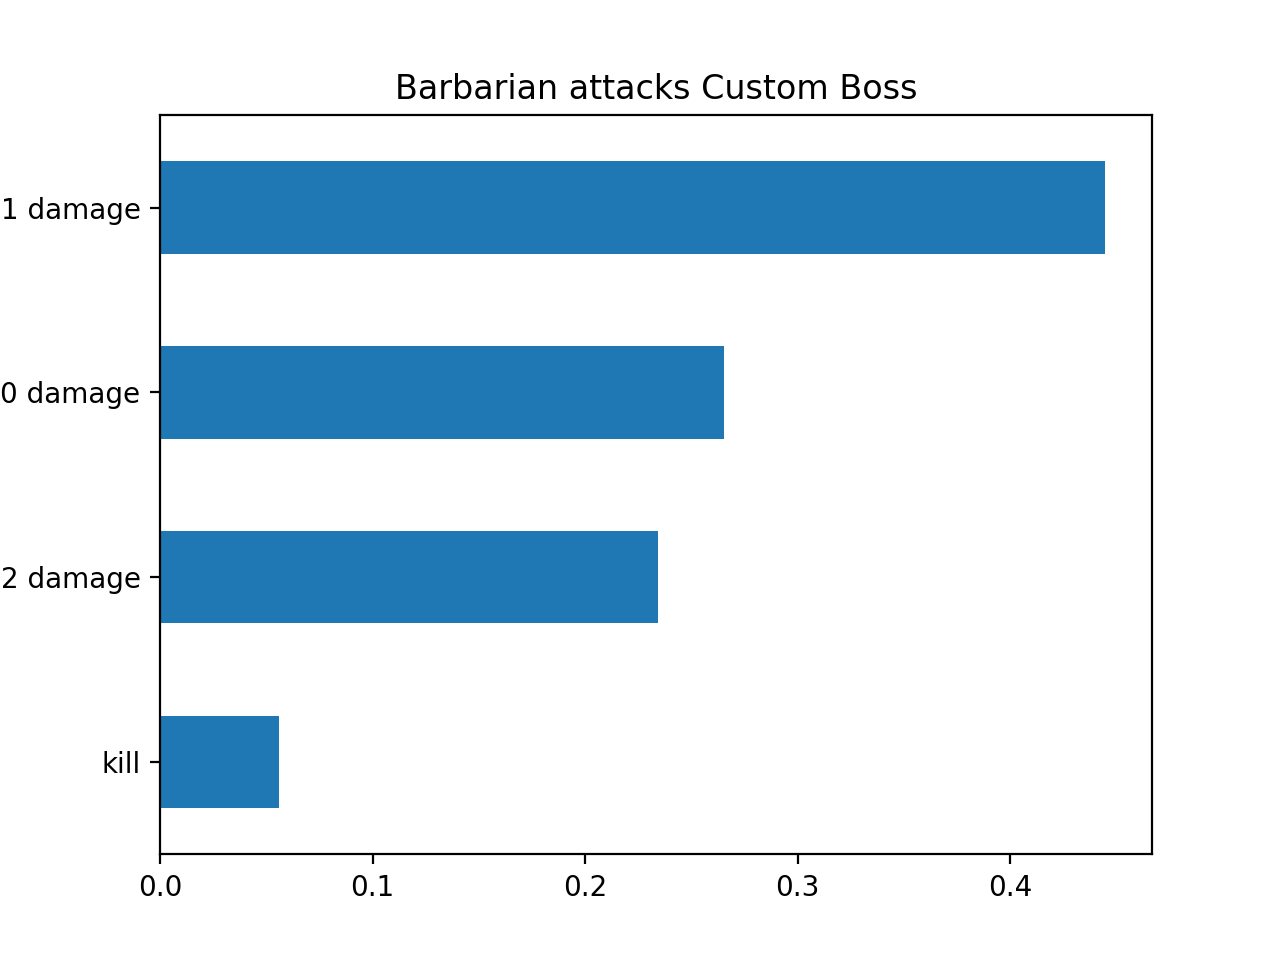

kill        0.055974
2 damage    0.234311
0 damage    0.265239
1 damage    0.444477
dtype: float64

In [80]:
barbarian.simulate_attack(dice, custom_boss)

<IPython.core.display.Javascript object>


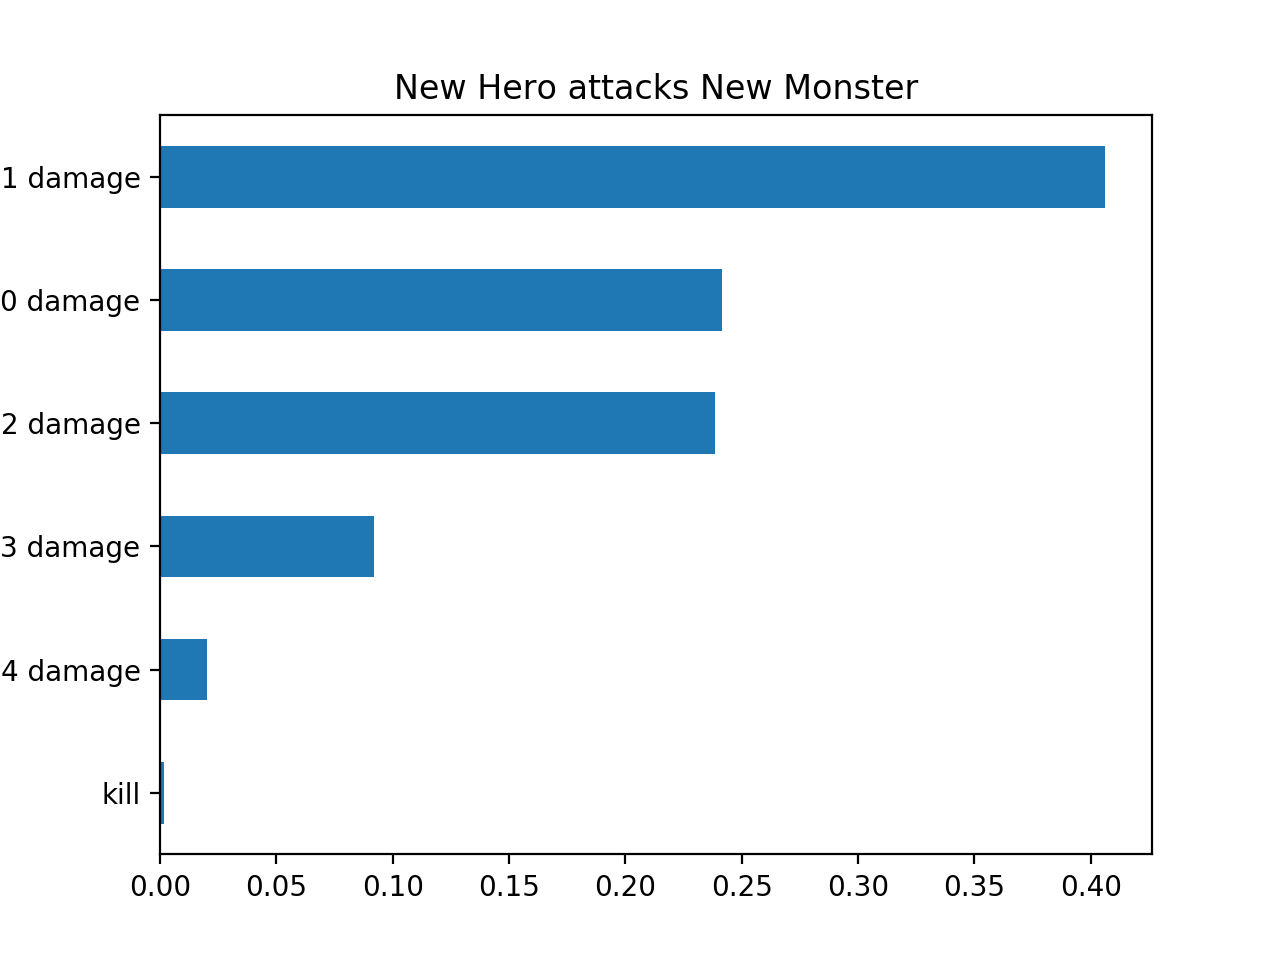

kill        0.001829
4 damage    0.020119
3 damage    0.091907
2 damage    0.238683
0 damage    0.241427
1 damage    0.406036
dtype: float64

In [76]:
# The fact that we use OOP allows us to very quickly change the rules and/or simulate combats between new creatures
fair_dice = Dice_model(1/3, 1/3, 1/3)
new_hero = Creature("New Hero", 5, 3, 1)
new_monster = Creature("New Monster", 1, 2, 5)
new_hero.simulate_attack(fair_dice, new_monster)